# Appendix: Introduction to Natural Language Processing for the Social Sciences

The aim of this project is to see how the definition of privacy has evolved over time. Using the results, we can have a normative discussion around the unknown biases in interpretation.

## __1) Wrangling__

In [3]:
import os, os.path, pickle
import string, copy, itertools

import numpy as np
import pandas as pd

import gensim, nltk
import seaborn

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from collections import Counter
from sklearn.feature_extraction import stop_words

%matplotlib inline

In [493]:
# Loading pre-extracted Supreme Court files from pickle
with open('scCases.pkl', 'rb') as f:
    scData = pickle.load(f)

print(scData[1])

{'id': 1562, 'name': 'Montecalvo v. United States', 'name_abbreviation': 'Montecalvo v. United States', 'decision_date': '1977-05-16', 'docket_number': 'No. 76-6150', 'first_page': '918', 'last_page': '918', 'citations': [{'type': 'official', 'cite': '431 U.S. 918'}], 'volume': {'volume_number': '431'}, 'reporter': {'full_name': 'United States Reports'}, 'court': {'id': 9009, 'name': 'Supreme Court of the United States', 'name_abbreviation': 'U.S.', 'jurisdiction_url': None, 'slug': 'us'}, 'jurisdiction': {'id': 39, 'slug': 'us', 'name': 'U.S.', 'name_long': 'United States', 'whitelisted': False}, 'casebody': {'status': 'ok', 'data': {'head_matter': 'No. 76-6150.\nMontecalvo v. United States.', 'opinions': [{'author': None, 'text': 'C. A. 9th Cir. Certiorari denied.', 'type': 'majority'}], 'attorneys': [], 'parties': ['Montecalvo v. United States.'], 'judges': []}}}


In [494]:
# Load and drop all information not required
scDF = pd.DataFrame.from_dict(scData)
scDF = scDF.drop(columns=['citations', 'court', 'first_page', 'id', 
                          'jurisdiction', 'last_page', 'name', 'reporter', 'volume'])

# Cleaning docket numbers for potential merge
scDF['docket_number'].replace(regex=True, inplace=True, to_replace=r'[No. ]',value=r'')
scDF['docket_number'].replace(regex=True, inplace=True, to_replace=r'[;]',value=r',')

# Flattening court opinions
scDF['opinions'] = [scDF['casebody'][i]['data']['opinions'] for i in scDF.index]

allOpinions = []
opTypes = ['majority', 'dissent', 'concurrence', 'concurring-in-part-and-dissenting-in-part']
for opinions in scDF['opinions']:
    text = [opinion['text'] for opinion in opinions if opinion['type'] in opTypes]
    allOpinions.append(text)
    
scDF['opinion_text'] = [' '.join(text) for text in allOpinions]

In [495]:
# Drop uneccessary baggage 
scDF = scDF.drop(columns=['casebody', 'opinions'])
scDF = scDF.drop_duplicates()

# Correct data object type and adding year column
scDF['decision_date'] = pd.to_datetime(scDF['decision_date'])
scDF['year'] = scDF['decision_date'].dt.year

# Cleaning opinions
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.lower())
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('“', ''))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('”', ''))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('•', ''))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('—', ''))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('■', ''))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('¿', ''))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('§', 'section')) 
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('\n', ' ')) 
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('  ', ' '))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace(' u. s. ', 'us')) 
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace(' u.s. ', 'us')) 
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace(' v. ', 'v')) 
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace(' f. supp. ', 'fsupp'))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace(' u. s. c. ', 'usc'))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('cir.', 'circuit'))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('c. a.', 'court of appeal'))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('ct.', 'court'))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('app.', 'appeal'))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('dist.', 'district'))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('4th amendment', 'fourthamendment'))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('fourth amendment', 'fourthamendment'))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.replace('private life', 'privatelife'))
scDF['opinion_text'] = scDF['opinion_text'].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Including length to filter non-material opinions
scDF['text_count'] = scDF['opinion_text'].apply(lambda x: len(x))
scDF.head()

,decision_date,docket_number,name_abbreviation,opinion_text,year,text_count
0,1977-05-23,76-6301,Carpenter v. South Dakota,court of appeal 8th circuit certiorari denied,1977,45
1,1977-05-16,76-6150,Montecalvo v. United States,court of appeal 9th circuit certiorari denied,1977,45
2,1977-05-31,76-333,"United Air Lines, Inc. v. Evans",mr justice stevens delivered the opinion of th...,1977,17697
3,1977-05-02,76-6501,Spanier v. United States,court of appeal 9th circuit certiorari denied,1977,45
4,1977-05-31,76-777,Connor v. Finch,mr justice stewart delivered the opinion of th...,1977,50415


In [496]:
scDF_sample = scDF[scDF['text_count']>1000]
scDF_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28879 entries, 2 to 328306
Data columns (total 6 columns):
decision_date        28879 non-null datetime64[ns]
docket_number        28879 non-null object
name_abbreviation    28879 non-null object
opinion_text         28879 non-null object
year                 28879 non-null int64
text_count           28879 non-null int64
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.5+ MB


In [533]:
scDF_sample.head()

,decision_date,docket_number,name_abbreviation,opinion_text,year,text_count
2,1977-05-31,76-333,"United Air Lines, Inc. v. Evans",mr justice stevens delivered the opinion of th...,1977,17697
4,1977-05-31,76-777,Connor v. Finch,mr justice stewart delivered the opinion of th...,1977,50415
29,1977-06-09,76-404,Illinois Brick Co. v. Illinois,mr justice white delivered the opinion of the ...,1977,89420
51,1977-05-23,75-1775,Massachusetts v. Westcott,per curiam respondent westcott was arrested fo...,1977,3152
55,1977-05-16,76-1005,Pressler v. Blumenthal,per curiam the motion of we the people for lea...,1977,1090


In [541]:
# Sample opinion
scDF_sample['opinion_text'][51]

'per curiam respondent westcott was arrested for violating a massachusetts statute that prohibits nonresidents of the commonwealth of massachusetts from dragging for fish by beam or otter trawl in vineyard sound during july august and september 1 after he was found guilty he pursued his right to de novo review and filed a motion to dismiss the complaint the massachusetts supreme judicial court granted direct appellate review and ordered the complaint dismissed on the ground that the statute violated the privileges and immunities clause of the united states constitution art iv section 3 cl 2 344 n e 2d 411 we granted certiorari 429us815 1976 our decision today in douglasvseacoast products inc ante p 265 suggests that there may be a statutory basis to provide respondent the relief he seeks thereby making it unnecessary to decide the constitutional question presented douglas holds that federal law preempts the states from denying vessels that are federally enrolled and licensed for the fi

In [20]:
# Tokenising words
scDF_sample['tokens'] = scDF_sample['opinion_text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])

In [21]:
# Grouping opinions into decades with a base (pre-1979). 
# To reduce the computationally expensive calculations we only use 5 decades

scDF_base = scDF_sample[scDF_sample['year']<=1978]
scDF_base['year'] = 1978
scDF_base = scDF_base.groupby('year')['tokens'].sum()
scDF_base = scDF_base.reset_index()

scDF_88 = scDF_sample[(scDF_sample['year'] > 1978) & (scDF_sample['year'] <= 1988)]
scDF_88['year'] = 1988
scDF_88 = scDF_88.groupby('year')['tokens'].sum()
scDF_88 = scDF_88.reset_index()

scDF_98 = scDF_sample[(scDF_sample['year'] > 1988) & (scDF_sample['year'] <= 1998)]
scDF_98['year'] = 1998
scDF_98 = scDF_98.groupby('year')['tokens'].sum()
scDF_98 = scDF_98.reset_index()

scDF_08 = scDF_sample[(scDF_sample['year'] > 1998) & (scDF_sample['year'] <= 2008)]
scDF_08['year'] = 2008
scDF_08 = scDF_08.groupby('year')['tokens'].sum()
scDF_08 = scDF_08.reset_index()

scDF_18 = scDF_sample[(scDF_sample['year'] > 2008) & (scDF_sample['year'] <= 2018)]
scDF_18['year'] = 2018
scDF_18 = scDF_18.groupby('year')['tokens'].sum()
scDF_18 = scDF_18.reset_index()

# Concatenate the groups
scDF_grouped = pd.concat([scDF_base, scDF_88, scDF_98, scDF_08, scDF_18], ignore_index=True)

In [22]:
# Normalise tokens and filter stop and infrequent words
scDF_grouped['norm_tokens'] = scDF_grouped['tokens'].apply(lambda x: 
                                                           [lucem_illud.normalizeTokens(s, 
                                                                                        stopwordLst = stop_words.ENGLISH_STOP_WORDS, 
                                                                                        stemmer = None) 
                                                            for s in x])
scDF_grouped.head()

,year,tokens,norm_tokens
0,1978,"[[mr, justice, stevens, delivered, the, opinio...","[[mr, justice, stevens, delivered, opinion, co..."
1,1988,"[[court, of, appeal, 11th, circuit, the, order...","[[court, appeal, circuit, order, heretofore, e..."
2,1998,"[[justice, brennan, delivered, the, opinion, o...","[[justice, brennan, delivered, opinion, court,..."
3,2008,"[[justice, breyer, delivered, the, opinion, of...","[[justice, breyer, delivered, opinion, court, ..."
4,2018,"[[justice, thomas, delivered, the, opinion, of...","[[justice, thomas, delivered, opinion, court, ..."


In [550]:
# Opinions have been grouped by document so each list of tokens represent an opinion.

print('Sample Opinions from 1978:\n', scDF_grouped['norm_tokens'][0][3:5])

Sample Opinions from 1978:
 [['curiam', 'respondent', 'westcott', 'arrested', 'violating', 'massachusetts', 'statute', 'prohibits', 'nonresidents', 'commonwealth', 'massachusetts', 'dragging', 'fish', 'beam', 'otter', 'trawl', 'vineyard', 'sound', 'july', 'august', 'september', 'guilty', 'pursued', 'right', 'novo', 'review', 'filed', 'motion', 'dismiss', 'complaint', 'massachusetts', 'supreme', 'judicial', 'court', 'granted', 'direct', 'appellate', 'review', 'ordered', 'complaint', 'dismissed', 'ground', 'statute', 'violated', 'privileges', 'immunities', 'clause', 'united', 'states', 'constitution', 'art', 'iv', 'section', 'cl', 'n', 'e', 'granted', 'certiorari', 'decision', 'today', 'douglasvseacoast', 'products', 'ante', 'p', 'suggests', 'statutory', 'basis', 'provide', 'respondent', 'relief', 'seeks', 'making', 'unnecessary', 'decide', 'constitutional', 'question', 'presented', 'douglas', 'holds', 'federal', 'law', 'preempts', 'states', 'denying', 'vessels', 'federally', 'enrolled',

In [23]:
scTokens = scDF_grouped.drop(columns=['tokens'])
scPkl = open('scNorm_tokens.pkl', 'wb')
pickle.dump(scTokens, scPkl)

## __2) Descriptive Statistics__

### General Characteristics

First, let's see what the general characteristics look like. This will require filtering out stopwords to ensure that we get an accurate depiction of the vocabulary.

Number of opinions: 328,306</br>
Number of judges: 112</br>
Opinions with > 1,000 characters: 28,879</br>
Timespan: Oct 1799-Oct 2018

In [498]:
def createDict(norm_text):
    wordlist = [review.split(' ') for review in norm_text] 
    wordlist = [word for review in wordlist for word in review] 
    vocab_dict = Counter(wordlist) 
    for word in list(vocab_dict):
        if word in stop_words.ENGLISH_STOP_WORDS or word=='' or word=="":
            del vocab_dict[word]
    return vocab_dict

def meanLength(norm_text):
    review_lengths = []
    for review in norm_text:
        review_lengths.append(len(review.split(' ')))
    return sum(review_lengths)/len(review_lengths)

In [503]:
# As we only use a sample of opinions (>1000 characters), our descriptive stats below relate to our sample
scDict = createDict(scDF_sample['opinion_text'])

print('Number of unique words in opinions:', len(scDict))
print('\n')
print('Most common words in opinions:', scDict.most_common(20))
print('\n')
print('Average length of opinions:', meanLength(scDF_sample.opinion_text))

Number of unique words in opinions: 683156


Most common words in opinions: [('court', 710418), ('state', 344987), ('section', 309751), ('case', 287558), ('states', 274293), ('act', 243007), ('law', 218205), ('united', 201767), ('federal', 144657), ('said', 142292), ('district', 137480), ('right', 135072), ('shall', 134860), ('congress', 134615), ('question', 129340), ('judgment', 127568), ('statute', 124228), ('opinion', 120781), ('property', 120298), ('time', 118560)]


Average length of opinions: 3573.275528931057


### Word Frequency Analysis

In [502]:
# Now we analyse our word frequencies as these are important for our embedding stability. 

lowFreq = []
for word in list(scDict):
    if scDict[word] < 100:
        lowFreq.append(word)

# No. of words that occur > 100
print('No. of unique words > 100 occurences:', len(scDict)-len(lowFreq))

No. of unique words > 100 occurences: 21197


No handles with labels found to put in legend.


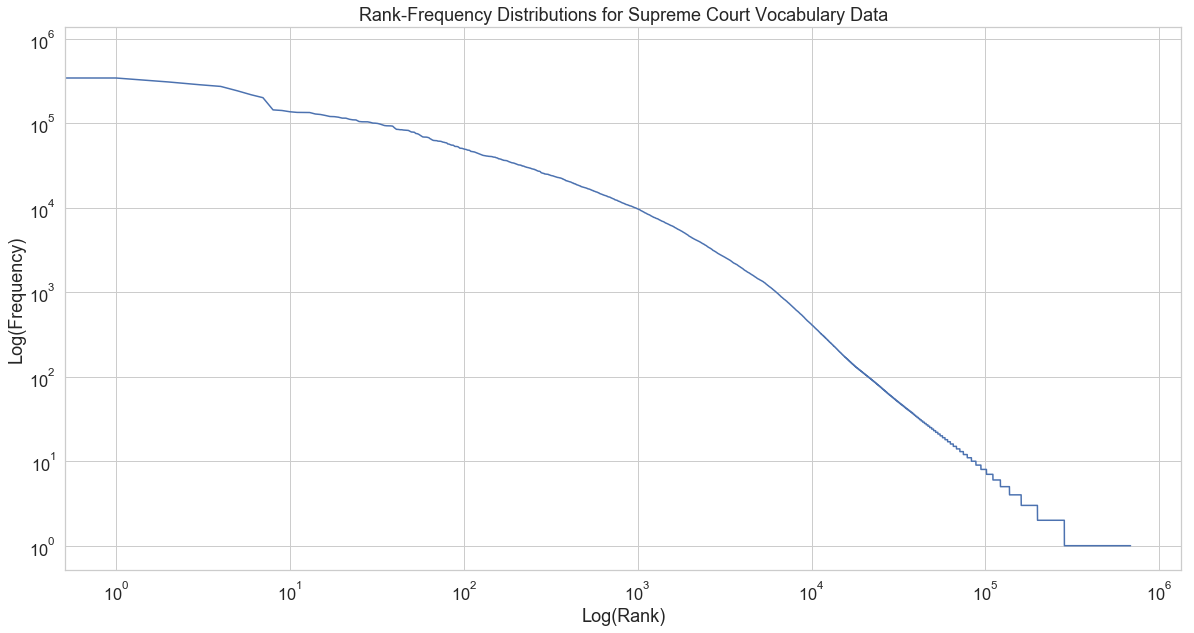

In [507]:
seaborn.set(font_scale=1.5)
seaborn.set_style("whitegrid")
plt.figure(figsize=(20,10))
plt.loglog(range(len(scDict)), sorted(scDict.values(), reverse=True))
plt.title('Rank-Frequency Distributions for Supreme Court Vocabulary Data')
plt.xlabel('Log(Rank)')
plt.ylabel('Log(Frequency)')
plt.legend()
# plt.savefig('scdf_zipf.png', bbox_inches='tight')
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law).

## __3) Diachronic Word Emdeddings__

In [10]:
from glove import Corpus, Glove
import cython
import scipy.sparse

from collections import defaultdict
from gensim import utils, matutils
from scipy import sparse
from scipy.sparse import linalg

In [11]:
with open('scNorm_tokens.pkl', 'rb') as t:
    scDF_grouped = pickle.load(t)

In [164]:
# Parameters controlling what is to be computed: how many dimensions, window size etc.
DIM = 100
WORKERS = 12
WINDOW = 5
COUNT = 100

### __(a) CBOW Implementation__

In [50]:
W2V_CBOW78 = gensim.models.word2vec.Word2Vec(scDF_grouped[:1]['norm_tokens'].sum(), size=DIM,  min_count=COUNT, 
                                           window=WINDOW, workers=WORKERS, sg=0, hs=0)
W2V_CBOW78.most_similar('privacy')

[('intrusions', 0.7715179324150085),
 ('intrusion', 0.7018710374832153),
 ('associational', 0.6634266376495361),
 ('invasions', 0.662422239780426),
 ('fourthamendment', 0.6562724113464355),
 ('invasion', 0.6495582461357117),
 ('sanctity', 0.6327649354934692),
 ('confidentiality', 0.6055096387863159),
 ('freedoms', 0.5913448333740234),
 ('searches', 0.5748980045318604)]

In [51]:
CBOW78DF = pd.DataFrame(W2V_CBOW78.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_CBOW78 = gensim.models.word2vec.Word2Vec(scDF_grouped[:1]['norm_tokens'].sum(), 
                                                 size=DIM,  min_count=COUNT, window=WINDOW, 
                                                 workers=WORKERS, sg=0, hs=0)
    tempDF = pd.DataFrame(W2V_CBOW78.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])
    CBOW78DF = CBOW78DF.merge(tempDF, how='left', on='word', left_index=True)
    
CBOW78DF.to_csv('CBOW78DF.csv', index=False)

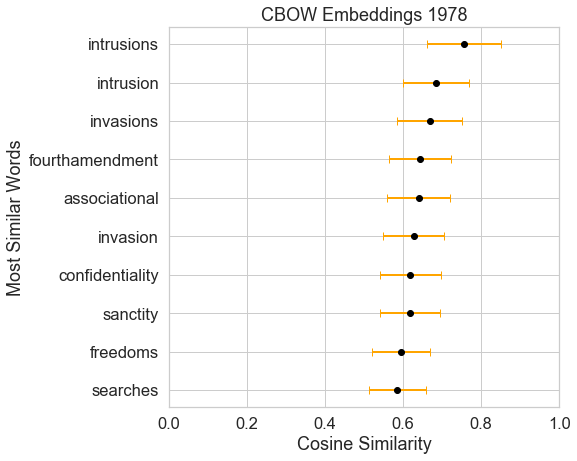

In [512]:
CBOW78DF['mean'] = CBOW78DF.mean(axis=1)
CBOW78DF['std'] = CBOW78DF.std(axis=1)

CBOW78DF = CBOW78DF.sort_values(by='mean', ascending=True)
CBOW78DF = CBOW78DF.reset_index()
CBOW78DF = CBOW78DF.drop(columns=['index'])

x = CBOW78DF[5:]['mean']
error = CBOW78DF[5:]['std']
y = CBOW78DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('CBOW Embeddings 1978')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('cbow1978.png', bbox_inches='tight')
plt.show()

In [52]:
W2V_CBOW88 = gensim.models.word2vec.Word2Vec(scDF_grouped[:2]['norm_tokens'].sum(), size=DIM,  min_count=COUNT, 
                                           window=WINDOW, workers=WORKERS, sg=0, hs=0)
W2V_CBOW88.most_similar('privacy')

[('intrusions', 0.6981357336044312),
 ('intrusion', 0.6811184287071228),
 ('sanctity', 0.6561369895935059),
 ('fourthamendment', 0.6511359214782715),
 ('invasions', 0.636959969997406),
 ('invasion', 0.5960270166397095),
 ('associational', 0.5875344276428223),
 ('searches', 0.5822386741638184),
 ('inviolability', 0.5639979243278503),
 ('expectations', 0.5616428852081299)]

In [53]:
CBOW88DF = pd.DataFrame(W2V_CBOW88.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_CBOW88 = gensim.models.word2vec.Word2Vec(scDF_grouped[:2]['norm_tokens'].sum(), 
                                                 size=DIM,  min_count=COUNT, window=WINDOW, 
                                                 workers=WORKERS, sg=0, hs=0)
    tempDF = pd.DataFrame(W2V_CBOW88.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])
    CBOW88DF = CBOW88DF.merge(tempDF, how='left', on='word', left_index=True)
    
CBOW88DF.to_csv('CBOW88DF.csv', index=False)

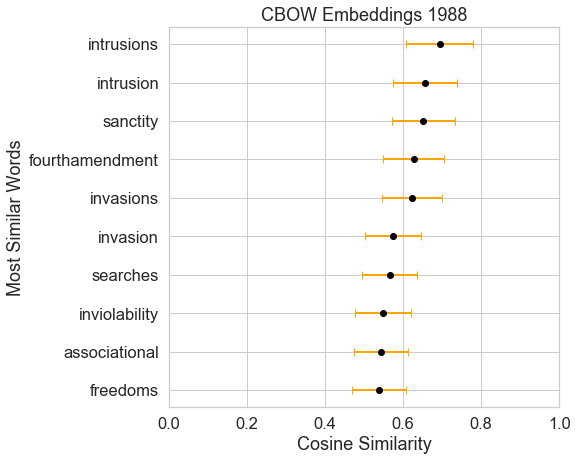

In [513]:
CBOW88DF['mean'] = CBOW88DF.mean(axis=1)
CBOW88DF['std'] = CBOW88DF.std(axis=1)

CBOW88DF = CBOW88DF.sort_values(by='mean', ascending=True)
CBOW88DF = CBOW88DF.reset_index()
CBOW88DF = CBOW88DF.drop(columns=['index'])

x = CBOW88DF[5:]['mean']
error = CBOW88DF[5:]['std']
y = CBOW88DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('CBOW Embeddings 1988')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('cbow1988.png', bbox_inches='tight')
plt.show()

In [54]:
W2V_CBOW98 = gensim.models.word2vec.Word2Vec(scDF_grouped[:3]['norm_tokens'].sum(), size=DIM,  min_count=COUNT, 
                                           window=WINDOW, workers=WORKERS, sg=0, hs=0)
W2V_CBOW98.most_similar('privacy')

[('intrusions', 0.6875451803207397),
 ('intrusion', 0.6488082408905029),
 ('homeowner', 0.6456473469734192),
 ('sanctity', 0.6422878503799438),
 ('fourthamendment', 0.6238590478897095),
 ('invasions', 0.6101131439208984),
 ('anonymity', 0.5925043821334839),
 ('invasion', 0.590016782283783),
 ('searches', 0.5869744420051575),
 ('confidentiality', 0.5624843835830688)]

In [55]:
CBOW98DF = pd.DataFrame(W2V_CBOW98.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_CBOW98 = gensim.models.word2vec.Word2Vec(scDF_grouped[:3]['norm_tokens'].sum(), 
                                                 size=DIM,  min_count=COUNT, window=WINDOW, 
                                                 workers=WORKERS, sg=0, hs=0)
    tempDF = pd.DataFrame(W2V_CBOW98.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])
    CBOW98DF = CBOW98DF.merge(tempDF, how='left', on='word', left_index=True)
    
CBOW98DF.to_csv('CBOW98DF.csv', index=False)

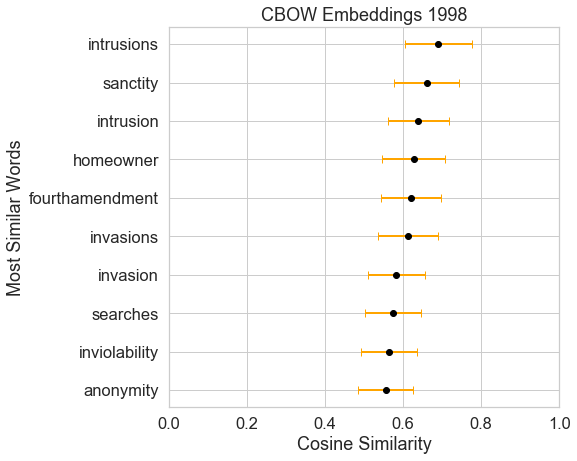

In [514]:
CBOW98DF['mean'] = CBOW98DF.mean(axis=1)
CBOW98DF['std'] = CBOW98DF.std(axis=1)

CBOW98DF = CBOW98DF.sort_values(by='mean', ascending=True)
CBOW98DF = CBOW98DF.reset_index()
CBOW98DF = CBOW98DF.drop(columns=['index'])

x = CBOW98DF[5:]['mean']
error = CBOW98DF[5:]['std']
y = CBOW98DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('CBOW Embeddings 1998')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('cbow1998.png', bbox_inches='tight')
plt.show()

In [56]:
W2V_CBOW08 = gensim.models.word2vec.Word2Vec(scDF_grouped[:4]['norm_tokens'].sum(), size=DIM,  min_count=COUNT, 
                                           window=WINDOW, workers=WORKERS, sg=0, hs=0)
W2V_CBOW08.most_similar('privacy')

[('intrusions', 0.6938438415527344),
 ('sanctity', 0.6660768985748291),
 ('intrusion', 0.6616233587265015),
 ('homeowner', 0.6566159129142761),
 ('fourthamendment', 0.6254117488861084),
 ('invasions', 0.5955450534820557),
 ('invasion', 0.5866763591766357),
 ('anonymity', 0.5739672780036926),
 ('searches', 0.5642539858818054),
 ('confidentiality', 0.5459603071212769)]

In [57]:
CBOW08DF = pd.DataFrame(W2V_CBOW08.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_CBOW08 = gensim.models.word2vec.Word2Vec(scDF_grouped[:4]['norm_tokens'].sum(), 
                                                 size=DIM,  min_count=COUNT, window=WINDOW, 
                                                 workers=WORKERS, sg=0, hs=0)
    tempDF = pd.DataFrame(W2V_CBOW08.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])
    CBOW08DF = CBOW08DF.merge(tempDF, how='left', on='word', left_index=True)
    
CBOW08DF.to_csv('CBOW08DF.csv', index=False)

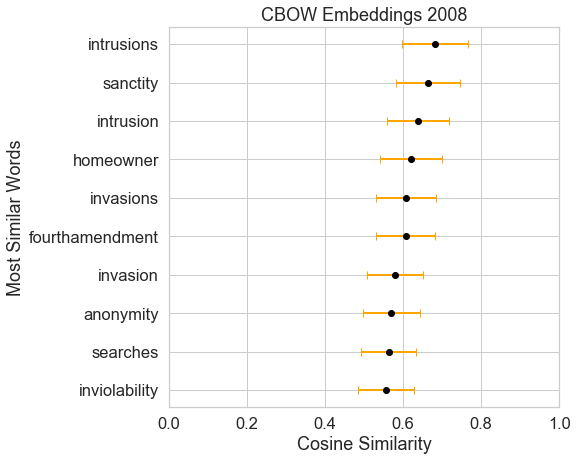

In [515]:
CBOW08DF['mean'] = CBOW08DF.mean(axis=1)
CBOW08DF['std'] = CBOW08DF.std(axis=1)

CBOW08DF = CBOW08DF.sort_values(by='mean', ascending=True)
CBOW08DF = CBOW08DF.reset_index()
CBOW08DF = CBOW08DF.drop(columns=['index'])

x = CBOW08DF[5:]['mean']
error = CBOW08DF[5:]['std']
y = CBOW08DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('CBOW Embeddings 2008')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('cbow2008.png', bbox_inches='tight')
plt.show()

In [58]:
W2V_CBOW18 = gensim.models.word2vec.Word2Vec(scDF_grouped[:5]['norm_tokens'].sum(), size=DIM,  min_count=COUNT, 
                                           window=WINDOW, workers=WORKERS, sg=0, hs=0)
W2V_CBOW18.most_similar('privacy')

[('intrusions', 0.6989879608154297),
 ('sanctity', 0.683599591255188),
 ('invasions', 0.6364945769309998),
 ('intrusion', 0.6363500356674194),
 ('homeowner', 0.6350557804107666),
 ('inviolability', 0.6136809587478638),
 ('anonymity', 0.6048062443733215),
 ('fourthamendment', 0.5999782085418701),
 ('invasion', 0.5987117290496826),
 ('investmentbacked', 0.5613685846328735)]

In [59]:
CBOW18DF = pd.DataFrame(W2V_CBOW18.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_CBOW18 = gensim.models.word2vec.Word2Vec(scDF_grouped[:5]['norm_tokens'].sum(), 
                                                 size=DIM,  min_count=COUNT, window=WINDOW, 
                                                 workers=WORKERS, sg=0, hs=0)
    tempDF = pd.DataFrame(W2V_CBOW18.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])
    CBOW18DF = CBOW18DF.merge(tempDF, how='left', on='word', left_index=True)
    
CBOW18DF.to_csv('CBOW18DF.csv', index=False)

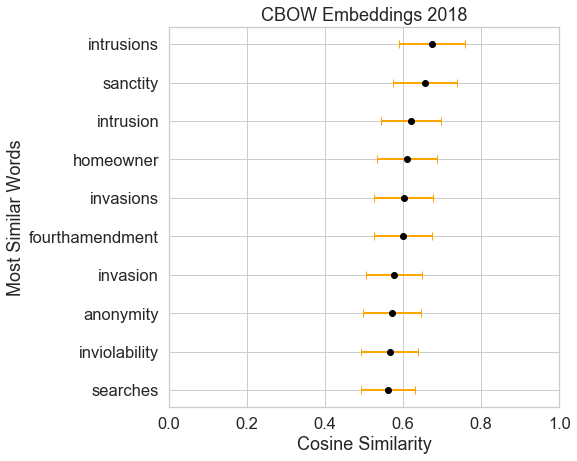

In [516]:
CBOW18DF['mean'] = CBOW18DF.mean(axis=1)
CBOW18DF['std'] = CBOW18DF.std(axis=1)

CBOW18DF = CBOW18DF.sort_values(by='mean', ascending=True)
CBOW18DF = CBOW18DF.reset_index()
CBOW18DF = CBOW18DF.drop(columns=['index'])

x = CBOW18DF[5:]['mean']
error = CBOW18DF[5:]['std']
y = CBOW18DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('CBOW Embeddings 2018')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('cbow2018.png', bbox_inches='tight')
plt.show()

In [398]:
CBOW_std = pd.concat([CBOW78DF['std'], CBOW88DF['std'], CBOW98DF['std'], CBOW08DF['std'], CBOW18DF['std']], axis=1, ignore_index=True)

### __(b) SGNS Implementation__

In [165]:
W2V_SGNS78 = gensim.models.word2vec.Word2Vec(scDF_grouped[:1]['norm_tokens'].sum(), size=DIM, min_count=COUNT, 
                                           window=WINDOW, workers=WORKERS, sg=1, hs=0)
W2V_SGNS78.most_similar('privacy')

[('intrusions', 0.7802588939666748),
 ('intrusion', 0.7586289644241333),
 ('fourthamendment', 0.6997361779212952),
 ('invasions', 0.6431229710578918),
 ('searches', 0.6408265829086304),
 ('invasion', 0.6305525302886963),
 ('griswoldvconnecticut', 0.6274293661117554),
 ('freedoms', 0.6070237159729004),
 ('search', 0.6015085577964783),
 ('terryvohio', 0.5868186354637146)]

In [166]:
SGNS78DF = pd.DataFrame(W2V_SGNS78.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_SGNS78 = gensim.models.word2vec.Word2Vec(scDF_grouped[:1]['norm_tokens'].sum(), 
                                                 size=DIM,  min_count=COUNT, window=WINDOW, 
                                                 workers=WORKERS, sg=1, hs=0)
    tempDF = pd.DataFrame(W2V_SGNS78.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])
    SGNS78DF = SGNS78DF.merge(tempDF, how='left', on='word', left_index=True)
    
SGNS78DF.to_csv('SGNS78DF.csv', index=False)

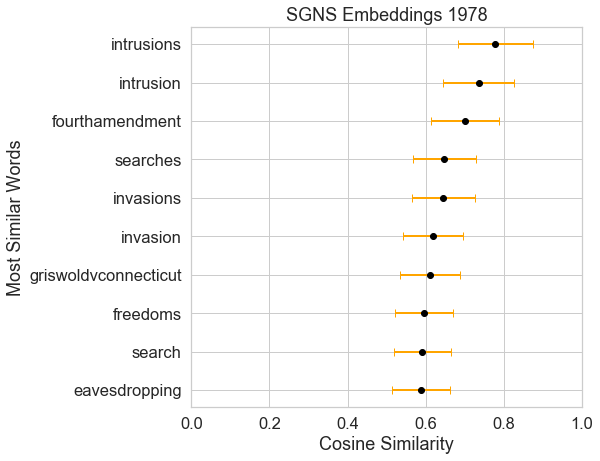

In [517]:
SGNS78DF['mean'] = SGNS78DF.mean(axis=1)
SGNS78DF['std'] = SGNS78DF.std(axis=1)

SGNS78DF = SGNS78DF.sort_values(by='mean', ascending=True)
SGNS78DF = SGNS78DF.reset_index()
SGNS78DF = SGNS78DF.drop(columns=['index'])

x = SGNS78DF[5:]['mean']
error = SGNS78DF[5:]['std']
y = SGNS78DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('SGNS Embeddings 1978')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('sgns1978.png', bbox_inches='tight')
plt.show()

In [167]:
W2V_SGNS88 = gensim.models.word2vec.Word2Vec(scDF_grouped[:2]['norm_tokens'].sum(), size=DIM, min_count=COUNT, 
                                           window=WINDOW, workers=WORKERS, sg=1, hs=0)
W2V_SGNS88.most_similar('privacy')

[('intrusions', 0.7521042823791504),
 ('intrusion', 0.7518737316131592),
 ('fourthamendment', 0.6994394063949585),
 ('katzvunited', 0.6583799719810486),
 ('expectations', 0.6516496539115906),
 ('searches', 0.6456072926521301),
 ('invasions', 0.6354020237922668),
 ('expectation', 0.6342723369598389),
 ('search', 0.6075125336647034),
 ('surveillance', 0.6033701300621033)]

In [168]:
SGNS88DF = pd.DataFrame(W2V_SGNS88.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_SGNS88 = gensim.models.word2vec.Word2Vec(scDF_grouped[:2]['norm_tokens'].sum(), 
                                                 size=DIM,  min_count=COUNT, window=WINDOW, 
                                                 workers=WORKERS, sg=1, hs=0)
    tempDF = pd.DataFrame(W2V_SGNS88.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])
    SGNS88DF = SGNS88DF.merge(tempDF, how='left', on='word', left_index=True)
    
SGNS88DF.to_csv('SGNS88DF.csv', index=False)

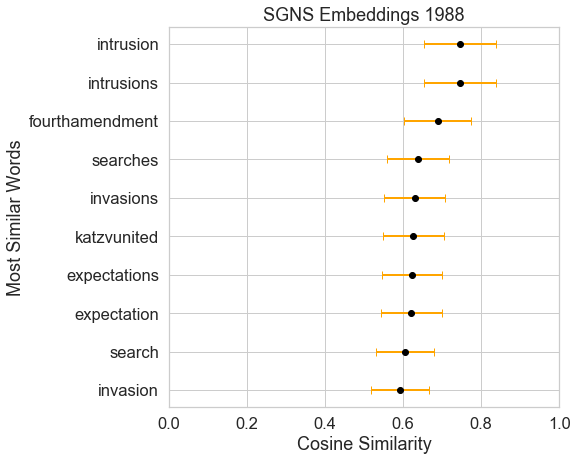

In [518]:
SGNS88DF['mean'] = SGNS88DF.mean(axis=1)
SGNS88DF['std'] = SGNS88DF.std(axis=1)

SGNS88DF = SGNS88DF.sort_values(by='mean', ascending=True)
SGNS88DF = SGNS88DF.reset_index()
SGNS88DF = SGNS88DF.drop(columns=['index'])

x = SGNS88DF[5:]['mean']
error = SGNS88DF[5:]['std']
y = SGNS88DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('SGNS Embeddings 1988')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('sgns1988.png', bbox_inches='tight')
plt.show()

In [169]:
W2V_SGNS98 = gensim.models.word2vec.Word2Vec(scDF_grouped[:3]['norm_tokens'].sum(), size=DIM, min_count=COUNT, 
                                           window=WINDOW, workers=WORKERS, sg=1, hs=0)
W2V_SGNS98.most_similar('privacy')

[('intrusion', 0.7498123645782471),
 ('intrusions', 0.7420135736465454),
 ('fourthamendment', 0.6932953000068665),
 ('searches', 0.6413638591766357),
 ('curtilage', 0.6326286792755127),
 ('expectation', 0.6304327249526978),
 ('homeowner', 0.6269301176071167),
 ('invasions', 0.6234186887741089),
 ('invasion', 0.6167134046554565),
 ('katzvunited', 0.6140211224555969)]

In [170]:
SGNS98DF = pd.DataFrame(W2V_SGNS98.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_SGNS98 = gensim.models.word2vec.Word2Vec(scDF_grouped[:3]['norm_tokens'].sum(), 
                                                 size=DIM, min_count=COUNT, window=WINDOW, 
                                                 workers=WORKERS, sg=1, hs=0)
    tempDF = pd.DataFrame(W2V_SGNS98.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])
    SGNS98DF = SGNS98DF.merge(tempDF, how='left', on='word', left_index=True)
    
SGNS98DF.to_csv('SGNS98DF.csv', index=False)

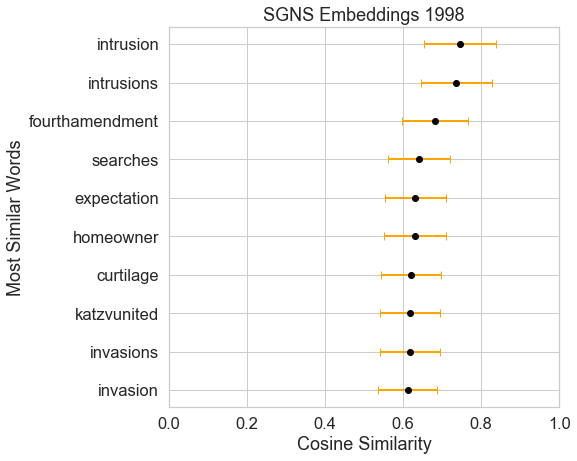

In [519]:
SGNS98DF['mean'] = SGNS98DF.mean(axis=1)
SGNS98DF['std'] = SGNS98DF.std(axis=1)

SGNS98DF = SGNS98DF.sort_values(by='mean', ascending=True)
SGNS98DF = SGNS98DF.reset_index()
SGNS98DF = SGNS98DF.drop(columns=['index'])

x = SGNS98DF[5:]['mean']
error = SGNS98DF[5:]['std']
y = SGNS98DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('SGNS Embeddings 1998')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('sgns1998.png', bbox_inches='tight')
plt.show()

In [171]:
W2V_SGNS08 = gensim.models.word2vec.Word2Vec(scDF_grouped[:4]['norm_tokens'].sum(), size=DIM, min_count=COUNT, 
                                           window=WINDOW, workers=WORKERS, sg=1, hs=0)
W2V_SGNS08.most_similar('privacy')

[('intrusions', 0.778453528881073),
 ('intrusion', 0.7541861534118652),
 ('fourthamendment', 0.696357250213623),
 ('expectation', 0.6575192213058472),
 ('searches', 0.6545114517211914),
 ('curtilage', 0.6377969980239868),
 ('katzvunited', 0.6335813999176025),
 ('search', 0.6299523711204529),
 ('expectations', 0.6257408857345581),
 ('invasions', 0.6196633577346802)]

In [172]:
SGNS08DF = pd.DataFrame(W2V_SGNS08.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_SGNS08 = gensim.models.word2vec.Word2Vec(scDF_grouped[:4]['norm_tokens'].sum(), 
                                                 size=DIM, min_count=COUNT, window=WINDOW, 
                                                 workers=WORKERS, sg=1, hs=0)
    tempDF = pd.DataFrame(W2V_SGNS08.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])
    SGNS08DF = SGNS08DF.merge(tempDF, how='left', on='word', left_index=True)
    
SGNS08DF.to_csv('SGNS08DF.csv', index=False)

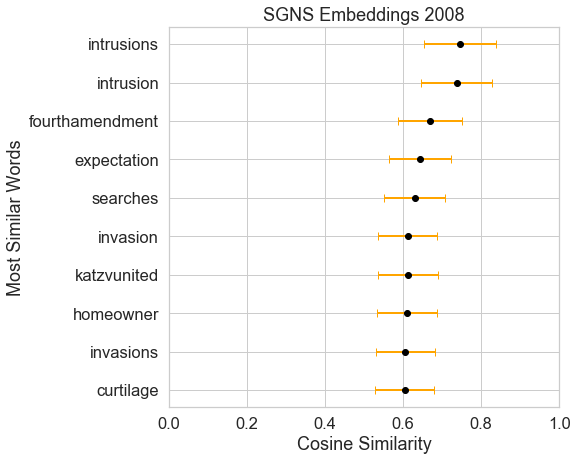

In [520]:
SGNS08DF['mean'] = SGNS08DF.mean(axis=1)
SGNS08DF['std'] = SGNS08DF.std(axis=1)

SGNS08DF = SGNS08DF.sort_values(by='mean', ascending=True)
SGNS08DF = SGNS08DF.reset_index()
SGNS08DF = SGNS08DF.drop(columns=['index'])

x = SGNS08DF[5:]['mean']
error = SGNS08DF[5:]['std']
y = SGNS08DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('SGNS Embeddings 2008')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('sgns2008.png', bbox_inches='tight')
plt.show()

In [173]:
W2V_SGNS18 = gensim.models.word2vec.Word2Vec(scDF_grouped[:5]['norm_tokens'].sum(), size=DIM, min_count=COUNT, 
                                           window=WINDOW, workers=WORKERS, sg=1, hs=0)
W2V_SGNS18.most_similar('privacy')

[('intrusions', 0.7486649751663208),
 ('intrusion', 0.7340254783630371),
 ('fourthamendment', 0.6755092144012451),
 ('expectation', 0.650266170501709),
 ('searches', 0.6384943723678589),
 ('katzvunited', 0.6371957063674927),
 ('invasion', 0.6248700022697449),
 ('homeowner', 0.6213486194610596),
 ('expectations', 0.6155259609222412),
 ('invasions', 0.6072031259536743)]

In [174]:
SGNS18DF = pd.DataFrame(W2V_SGNS18.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_SGNS18 = gensim.models.word2vec.Word2Vec(scDF_grouped[:5]['norm_tokens'].sum(), 
                                                 size=DIM, min_count=COUNT, window=WINDOW, 
                                                 workers=WORKERS, sg=1, hs=0)
    tempDF = pd.DataFrame(W2V_SGNS18.most_similar('privacy', topn=15), columns=['word', 'cosine_sim'])
    SGNS18DF = SGNS18DF.merge(tempDF, how='left', on='word', left_index=True)
    
SGNS18DF.to_csv('SGNS18DF.csv', index=False)

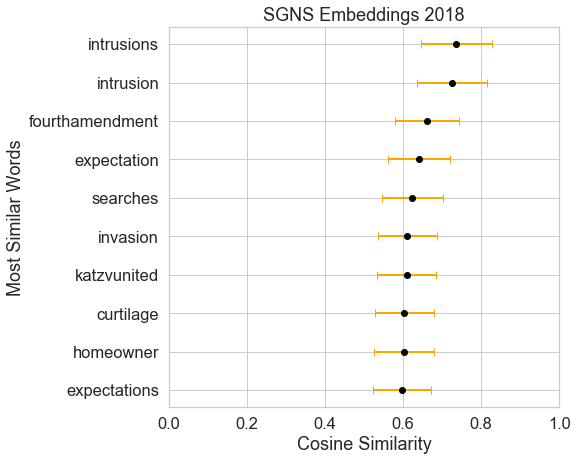

In [521]:
SGNS18DF['mean'] = SGNS18DF.mean(axis=1)
SGNS18DF['std'] = SGNS18DF.std(axis=1)

SGNS18DF = SGNS18DF.sort_values(by='mean', ascending=True)
SGNS18DF = SGNS18DF.reset_index()
SGNS18DF = SGNS18DF.drop(columns=['index'])

x = SGNS18DF[5:]['mean']
error = SGNS18DF[5:]['std']
y = SGNS18DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('SGNS Embeddings 2018')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('sgns2018.png', bbox_inches='tight')
plt.show()

In [404]:
SGNS_std = pd.concat([SGNS78DF['std'], SGNS88DF['std'], SGNS98DF['std'], SGNS08DF['std'], SGNS18DF['std']], axis=1, ignore_index=True)

### __(c) LSA Implementation__

In [291]:
class svdModel(object):
    def __init__(self, corpus, id2word, s_exponent=0.0):
        lsi = gensim.models.LsiModel(corpus, id2word=id2word, num_topics=DIM, chunksize=2000)
        self.singular_scaled = lsi.projection.s ** s_exponent
        # embeddings = left singular vectors scaled by the (exponentiated) singular values
        self.word_vectors = lsi.projection.u * self.singular_scaled

In [292]:
def most_similar(model, positive=[], negative=[], topn=10):
    """
    Find the top-N most similar words. Positive words contribute positively towards the
    similarity, negative words negatively.

    `model.word_vectors` must be a matrix of word embeddings (already L2-normalized),
    and its format must be either 2d numpy (dense) or scipy.sparse.csr.

    """
    if isinstance(positive, str) and not negative:
        # allow calls like most_similar('dog'), as a shorthand for most_similar(['dog'])
        positive = [positive]

    # add weights for each word, if not already present; default to 1.0 for positive and -1.0 for negative words
    positive = [
        (word, 1.0) if isinstance(word, (str, np.ndarray)) else word
        for word in positive]
    negative = [
        (word, -1.0) if isinstance(word, (str, np.ndarray)) else word
        for word in negative]

    # compute the weighted average of all words
    all_words, mean = set(), []
    for word, weight in positive + negative:
        if isinstance(word, np.ndarray):
            mean.append(weight * word)
        elif word in model.word2id:
            word_index = model.word2id[word]
            mean.append(weight * model.word_vectors[word_index])
            all_words.add(word_index)
        else:
            raise KeyError("word '%s' not in vocabulary" % word)
    if not mean:
        raise ValueError("cannot compute similarity with no input")
    if scipy.sparse.issparse(model.word_vectors):
        mean = scipy.sparse.vstack(mean)
    else:
        mean = np.array(mean)
    mean = matutils.unitvec(mean.mean(axis=0)).astype(model.word_vectors.dtype)

    dists = model.word_vectors.dot(mean.T).flatten()
    if not topn:
        return dists
    best = np.argsort(dists)[::-1][:topn + len(all_words)]

    # ignore (don't return) words from the input
    result = [(model.id2word[sim], float(dists[sim])) for sim in best if sim not in all_words]

    return result[:topn]

In [293]:
dict78 = gensim.corpora.Dictionary(scDF_grouped[:1]['norm_tokens'].sum())
dict78.filter_extremes(no_below=COUNT)
corpus78 = [dict78.doc2bow(text) for text in scDF_grouped[:1]['norm_tokens'].sum()]
gensim.corpora.MmCorpus.serialize('scOpinions78.mm', corpus78)
scOpinions78 = gensim.corpora.MmCorpus('scOpinions78.mm')

W2V_SVD78 = svdModel(scOpinions78, dict78)

W2V_SVD78.id2word = dict78
W2V_SVD78.word2id = dict((v, k) for k, v in dict78.iteritems())
most_similar(W2V_SVD78, 'privacy')

[('search', 0.29473739087600015),
 ('appellant', 0.2762856273526908),
 ('materials', 0.23063901459915442),
 ('president', 0.2029215239263477),
 ('warrant', 0.1866312528429376),
 ('papers', 0.17430006068260406),
 ('fourthamendment', 0.17082537210224943),
 ('presidential', 0.1521712206833281),
 ('seizure', 0.1304805296663907),
 ('privilege', 0.11956890088136214)]

In [294]:
SVD78DF = pd.DataFrame(most_similar(W2V_SVD78, 'privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_SVD78 = svdModel(scOpinions78, dict78)
    W2V_SVD78.id2word = dict78
    W2V_SVD78.word2id = dict((v, k) for k, v in dict78.iteritems())
    
    tempDF = pd.DataFrame(most_similar(W2V_SVD78, 'privacy', topn=15), columns=['word', 'cosine_sim'])
    SVD78DF = SVD78DF.merge(tempDF, how='left', on='word', left_index=True)
    
SVD78DF.to_csv('SVD78DF.csv', index=False)

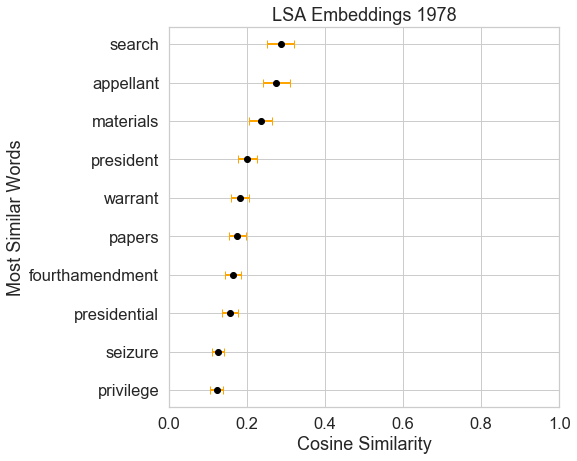

In [522]:
SVD78DF['mean'] = SVD78DF.mean(axis=1)
SVD78DF['std'] = SVD78DF.std(axis=1)

SVD78DF = SVD78DF.sort_values(by='mean', ascending=True)
SVD78DF = SVD78DF.reset_index()
SVD78DF = SVD78DF.drop(columns=['index'])

x = SVD78DF[5:]['mean']
error = SVD78DF[5:]['std']
y = SVD78DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('LSA Embeddings 1978')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('svd1978.png', bbox_inches='tight')
plt.show()

In [295]:
dict88 = gensim.corpora.Dictionary(scDF_grouped[:2]['norm_tokens'].sum())
dict88.filter_extremes(no_below=COUNT)
corpus88 = [dict88.doc2bow(text) for text in scDF_grouped[:2]['norm_tokens'].sum()]
gensim.corpora.MmCorpus.serialize('scOpinions88.mm', corpus88)
scOpinions88 = gensim.corpora.MmCorpus('scOpinions88.mm')

W2V_SVD88 = svdModel(scOpinions88, dict88)

W2V_SVD88.id2word = dict88
W2V_SVD88.word2id = dict((v, k) for k, v in dict88.iteritems())
most_similar(W2V_SVD88, 'privacy')

[('search', 0.388398168636114),
 ('warrant', 0.24994131862511088),
 ('appellant', 0.22000503127346432),
 ('fourthamendment', 0.20717051330703662),
 ('materials', 0.1550691814520697),
 ('president', 0.13444578880710828),
 ('papers', 0.12655880083471838),
 ('seizure', 0.1181722614059276),
 ('information', 0.11419538625468081),
 ('presidential', 0.11034015176691687)]

In [296]:
SVD88DF = pd.DataFrame(most_similar(W2V_SVD88, 'privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_SVD88 = svdModel(scOpinions88, dict88)
    W2V_SVD88.id2word = dict88
    W2V_SVD88.word2id = dict((v, k) for k, v in dict88.iteritems())
    
    tempDF = pd.DataFrame(most_similar(W2V_SVD88, 'privacy', topn=15), columns=['word', 'cosine_sim'])
    SVD88DF = SVD88DF.merge(tempDF, how='left', on='word', left_index=True)
    
SVD88DF.to_csv('SVD88DF.csv', index=False)

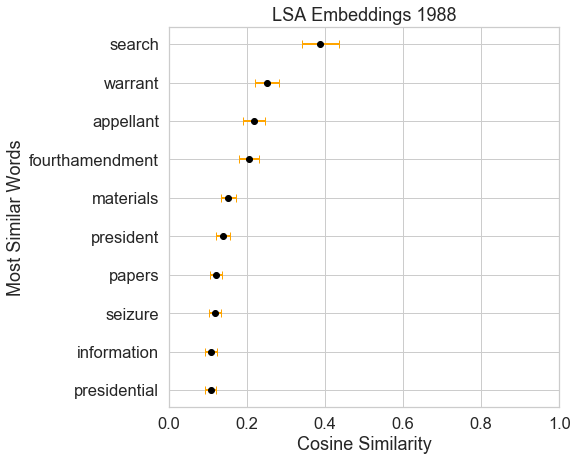

In [523]:
SVD88DF['mean'] = SVD88DF.mean(axis=1)
SVD88DF['std'] = SVD88DF.std(axis=1)

SVD88DF = SVD88DF.sort_values(by='mean', ascending=True)
SVD88DF = SVD88DF.reset_index()
SVD88DF = SVD88DF.drop(columns=['index'])

x = SVD88DF[5:]['mean']
error = SVD88DF[5:]['std']
y = SVD88DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('LSA Embeddings 1988')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('svd1988.png', bbox_inches='tight')
plt.show()

In [297]:
dict98 = gensim.corpora.Dictionary(scDF_grouped[:3]['norm_tokens'].sum())
dict98.filter_extremes(no_below=COUNT)
corpus98 = [dict98.doc2bow(text) for text in scDF_grouped[:3]['norm_tokens'].sum()]
gensim.corpora.MmCorpus.serialize('scOpinions98.mm', corpus98)
scOpinions98 = gensim.corpora.MmCorpus('scOpinions98.mm')

W2V_SVD98 = svdModel(scOpinions98, dict98)

W2V_SVD98.id2word = dict98
W2V_SVD98.word2id = dict((v, k) for k, v in dict98.iteritems())
most_similar(W2V_SVD98, 'privacy')

[('search', 0.4096774747626626),
 ('warrant', 0.26358503354968577),
 ('fourthamendment', 0.2300156332911782),
 ('appellant', 0.19034520164634353),
 ('information', 0.15190644447040447),
 ('materials', 0.1446558825013267),
 ('president', 0.1314618771715901),
 ('seizure', 0.11751019488070594),
 ('probable', 0.1161030298846147),
 ('papers', 0.11327840289250729)]

In [298]:
SVD98DF = pd.DataFrame(most_similar(W2V_SVD98, 'privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_SVD98 = svdModel(scOpinions98, dict98)
    W2V_SVD98.id2word = dict98
    W2V_SVD98.word2id = dict((v, k) for k, v in dict98.iteritems())
    
    tempDF = pd.DataFrame(most_similar(W2V_SVD98, 'privacy', topn=15), columns=['word', 'cosine_sim'])
    SVD98DF = SVD98DF.merge(tempDF, how='left', on='word', left_index=True)
    
SVD98DF.to_csv('SVD98DF.csv', index=False)

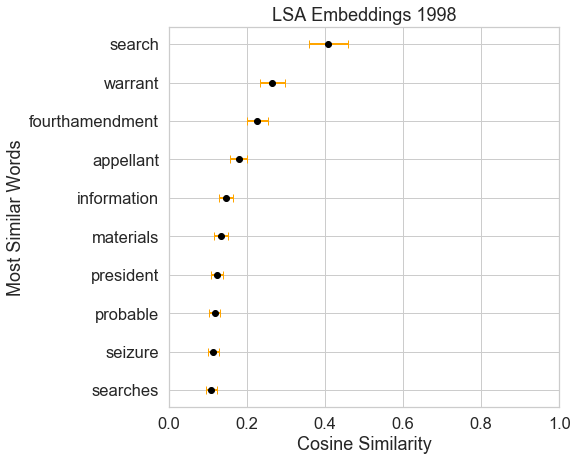

In [524]:
SVD98DF['mean'] = SVD98DF.mean(axis=1)
SVD98DF['std'] = SVD98DF.std(axis=1)

SVD98DF = SVD98DF.sort_values(by='mean', ascending=True)
SVD98DF = SVD98DF.reset_index()
SVD98DF = SVD98DF.drop(columns=['index'])

x = SVD98DF[5:]['mean']
error = SVD98DF[5:]['std']
y = SVD98DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('LSA Embeddings 1998')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('svd1998.png', bbox_inches='tight')
plt.show()

In [299]:
dict08 = gensim.corpora.Dictionary(scDF_grouped[:4]['norm_tokens'].sum())
dict08.filter_extremes(no_below=COUNT)
corpus08 = [dict08.doc2bow(text) for text in scDF_grouped[:4]['norm_tokens'].sum()]
gensim.corpora.MmCorpus.serialize('scOpinions08.mm', corpus08)
scOpinions08 = gensim.corpora.MmCorpus('scOpinions08.mm')

W2V_SVD08 = svdModel(scOpinions08, dict08)

W2V_SVD08.id2word = dict08
W2V_SVD08.word2id = dict((v, k) for k, v in dict08.iteritems())
most_similar(W2V_SVD08, 'privacy')

[('search', 0.4240763986389029),
 ('warrant', 0.27787914068814557),
 ('fourthamendment', 0.23370102778965823),
 ('information', 0.1721144339379382),
 ('appellant', 0.16765328897421838),
 ('materials', 0.12523406330112033),
 ('probable', 0.11892781232205954),
 ('president', 0.11587360640612948),
 ('searches', 0.11221269321728425),
 ('seizure', 0.11108493018963456)]

In [300]:
SVD08DF = pd.DataFrame(most_similar(W2V_SVD08, 'privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_SVD08 = svdModel(scOpinions08, dict08)
    W2V_SVD08.id2word = dict08
    W2V_SVD08.word2id = dict((v, k) for k, v in dict08.iteritems())
    
    tempDF = pd.DataFrame(most_similar(W2V_SVD08, 'privacy', topn=15), columns=['word', 'cosine_sim'])
    SVD08DF = SVD08DF.merge(tempDF, how='left', on='word', left_index=True)
    
SVD08DF.to_csv('SVD08DF.csv', index=False)

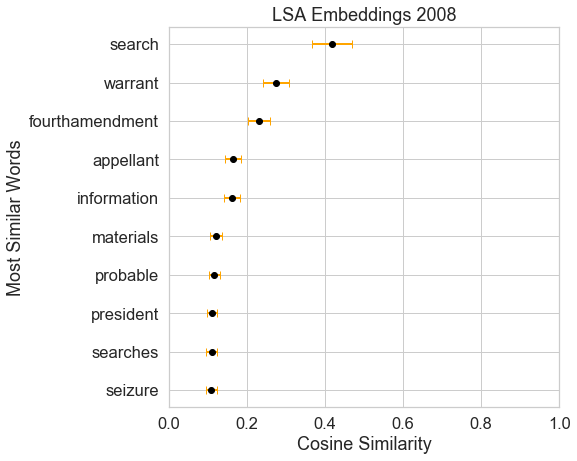

In [525]:
SVD08DF['mean'] = SVD08DF.mean(axis=1)
SVD08DF['std'] = SVD08DF.std(axis=1)

SVD08DF = SVD08DF.sort_values(by='mean', ascending=True)
SVD08DF = SVD08DF.reset_index()
SVD08DF = SVD08DF.drop(columns=['index'])

x = SVD08DF[5:]['mean']
error = SVD08DF[5:]['std']
y = SVD08DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('LSA Embeddings 2008')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('svd2008.png', bbox_inches='tight')
plt.show()

In [301]:
dict18 = gensim.corpora.Dictionary(scDF_grouped[:5]['norm_tokens'].sum())
dict18.filter_extremes(no_below=COUNT)
corpus18 = [dict18.doc2bow(text) for text in scDF_grouped[:5]['norm_tokens'].sum()]
gensim.corpora.MmCorpus.serialize('scOpinions18.mm', corpus18)
scOpinions18 = gensim.corpora.MmCorpus('scOpinions18.mm')

W2V_SVD18 = svdModel(scOpinions18, dict18)

W2V_SVD18.id2word = dict18
W2V_SVD18.word2id = dict((v, k) for k, v in dict18.iteritems())
most_similar(W2V_SVD18, 'privacy')

[('search', 0.41554141106712617),
 ('warrant', 0.2747929846539792),
 ('fourthamendment', 0.22820559730382076),
 ('information', 0.19328919910445003),
 ('appellant', 0.15835110759882168),
 ('probable', 0.11923787167255775),
 ('materials', 0.10940797567645169),
 ('seizure', 0.10764846362268121),
 ('searches', 0.10737312609474597),
 ('president', 0.10346172786746305)]

In [302]:
SVD18DF = pd.DataFrame(most_similar(W2V_SVD18, 'privacy', topn=15), columns=['word', 'cosine_sim'])

for i in range(50):
    W2V_SVD18 = svdModel(scOpinions18, dict18)
    W2V_SVD18.id2word = dict18
    W2V_SVD18.word2id = dict((v, k) for k, v in dict18.iteritems())
    
    tempDF = pd.DataFrame(most_similar(W2V_SVD18, 'privacy', topn=15), columns=['word', 'cosine_sim'])
    SVD18DF = SVD18DF.merge(tempDF, how='left', on='word', left_index=True)
    
SVD18DF.to_csv('SVD18DF.csv', index=False)

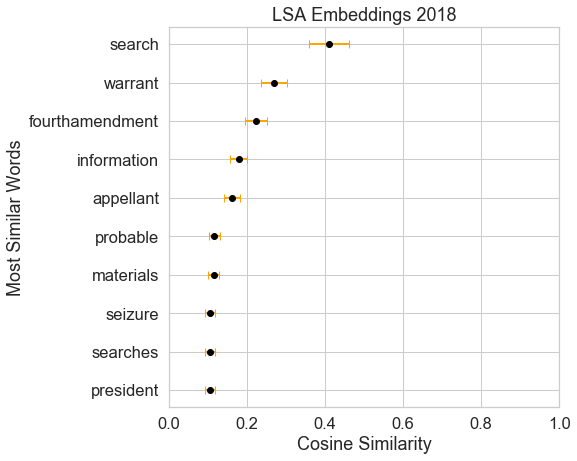

In [526]:
SVD18DF['mean'] = SVD18DF.mean(axis=1)
SVD18DF['std'] = SVD18DF.std(axis=1)

SVD18DF = SVD18DF.sort_values(by='mean', ascending=True)
SVD18DF = SVD18DF.reset_index()
SVD18DF = SVD18DF.drop(columns=['index'])

x = SVD18DF[5:]['mean']
error = SVD18DF[5:]['std']
y = SVD18DF[5:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('LSA Embeddings 2018')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('svd2018.png', bbox_inches='tight')
plt.show()

In [441]:
SVD_std = pd.concat([SVD78DF['std'], SVD88DF['std'], SVD98DF['std'], SVD08DF['std'], SVD18DF['std']], axis=1, ignore_index=True)

### __(d) GloVe Implementation__

In [329]:
corpus78 = Corpus(dictionary=W2V_SVD78.word2id)
corpus78.fit(scDF_grouped[:1]['norm_tokens'].sum(), window=WINDOW, ignore_missing=True)
glove78 = Glove(no_components=DIM, learning_rate=0.05)
glove78.fit(matrix=corpus78.matrix, epochs=10, no_threads=WORKERS, verbose=True)

Performing 10 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [330]:
glove78.add_dictionary(corpus78.dictionary)
glove78.most_similar('privacy', number=10)

[('intrusion', 0.8038308945425165),
 ('invasion', 0.7850198332794872),
 ('invasions', 0.727601001050401),
 ('intrusions', 0.7138784953791796),
 ('invaded', 0.6749342938536158),
 ('protects', 0.6526237772167458),
 ('expectation', 0.639587339803903),
 ('expectations', 0.6302894862413292),
 ('fourthamendment', 0.6260914696536239)]

In [331]:
glove78DF = pd.DataFrame(glove78.most_similar('privacy', number=15), columns=['word', 'cosine_sim'])

for i in range(50):
    glove78 = Glove(no_components=DIM, learning_rate=0.05)
    glove78.fit(matrix=corpus78.matrix, epochs=10, no_threads=WORKERS, verbose=True)
    glove78.add_dictionary(corpus78.dictionary)
    tempDF = pd.DataFrame(glove78.most_similar('privacy', number=15), columns=['word', 'cosine_sim'])
    glove78DF = glove78DF.merge(tempDF, how='left', on='word', left_index=True)
    
glove78DF.to_csv('glove78DF.csv', index=False)

Performing 10 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Performing 10 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Performing 10 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Performing 10 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Performing 10 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Performing 10 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Performing 10 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Performing 10 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8


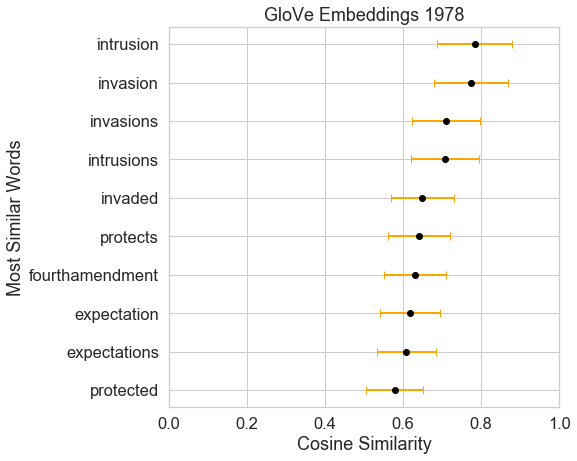

In [527]:
glove78DF['mean'] = glove78DF.mean(axis=1)
glove78DF['std'] = glove78DF.std(axis=1)

glove78DF = glove78DF.sort_values(by='mean', ascending=True)
glove78DF = glove78DF.reset_index()
glove78DF = glove78DF.drop(columns=['index'])

x = glove78DF[4:]['mean']
error = glove78DF[4:]['std']
y = glove78DF[4:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('GloVe Embeddings 1978')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('glove1978.png', bbox_inches='tight')
plt.show()

In [332]:
corpus88 = Corpus(dictionary=W2V_SVD88.word2id)
corpus88.fit(scDF_grouped[:2]['norm_tokens'].sum(), window=WINDOW, ignore_missing=True)
glove88 = Glove(no_components=DIM, learning_rate=0.05)
glove88.fit(matrix=corpus88.matrix, epochs=10, no_threads=WORKERS, verbose=True)

Performing 10 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [333]:
glove88.add_dictionary(corpus88.dictionary)
glove88.most_similar('privacy', number=10)

[('expectation', 0.7996225018349498),
 ('expectations', 0.7934422242809488),
 ('intrusion', 0.7414585130501504),
 ('invasion', 0.7356512747533901),
 ('intrusions', 0.7287542930746371),
 ('invasions', 0.6942082856047272),
 ('invaded', 0.6720539116323111),
 ('protects', 0.6056712860394131),
 ('implicated', 0.5874733013510083)]

In [334]:
glove88DF = pd.DataFrame(glove88.most_similar('privacy', number=15), columns=['word', 'cosine_sim'])

for i in range(50):
    glove88 = Glove(no_components=DIM, learning_rate=0.05)
    glove88.fit(matrix=corpus88.matrix, epochs=12, no_threads=WORKERS, verbose=True)
    glove88.add_dictionary(corpus88.dictionary)
    tempDF = pd.DataFrame(glove88.most_similar('privacy', number=15), columns=['word', 'cosine_sim'])
    glove88DF = glove88DF.merge(tempDF, how='left', on='word', left_index=True)
    
glove88DF.to_csv('glove88DF.csv', index=False)

Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
E

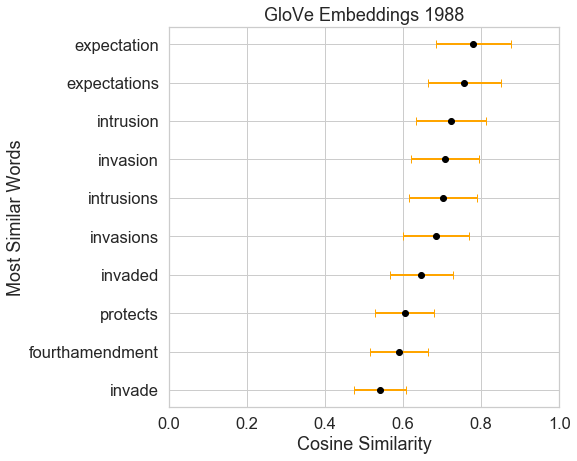

In [528]:
glove88DF['mean'] = glove88DF.mean(axis=1)
glove88DF['std'] = glove88DF.std(axis=1)

glove88DF = glove88DF.sort_values(by='mean', ascending=True)
glove88DF = glove88DF.reset_index()
glove88DF = glove88DF.drop(columns=['index'])

x = glove88DF[4:]['mean']
error = glove88DF[4:]['std']
y = glove88DF[4:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('GloVe Embeddings 1988')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('glove1988.png', bbox_inches='tight')
plt.show()

In [335]:
corpus98 = Corpus(dictionary=W2V_SVD98.word2id)
corpus98.fit(scDF_grouped[:3]['norm_tokens'].sum(), window=WINDOW, ignore_missing=True)
glove98 = Glove(no_components=DIM, learning_rate=0.05)
glove98.fit(matrix=corpus98.matrix, epochs=10, no_threads=WORKERS, verbose=True)

Performing 10 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [336]:
glove98.add_dictionary(corpus98.dictionary)
glove98.most_similar('privacy', number=10)

[('expectation', 0.7888025803126963),
 ('intrusion', 0.7542489318690918),
 ('invasion', 0.7433425304975122),
 ('intrusions', 0.7231544706490598),
 ('expectations', 0.7173735741239511),
 ('invasions', 0.7057932030971049),
 ('invaded', 0.6799592550380293),
 ('fourthamendment', 0.6143205862532052),
 ('protects', 0.590399800849389)]

In [337]:
glove98DF = pd.DataFrame(glove98.most_similar('privacy', number=15), columns=['word', 'cosine_sim'])

for i in range(50):
    glove98 = Glove(no_components=DIM, learning_rate=0.05)
    glove98.fit(matrix=corpus98.matrix, epochs=12, no_threads=WORKERS, verbose=True)
    glove98.add_dictionary(corpus98.dictionary)
    tempDF = pd.DataFrame(glove98.most_similar('privacy', number=15), columns=['word', 'cosine_sim'])
    glove98DF = glove98DF.merge(tempDF, how='left', on='word', left_index=True)
    
glove98DF.to_csv('glove98DF.csv', index=False)

Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
E

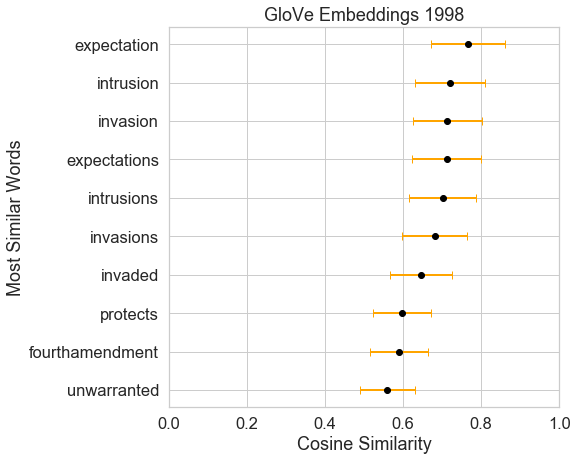

In [529]:
glove98DF['mean'] = glove98DF.mean(axis=1)
glove98DF['std'] = glove98DF.std(axis=1)

glove98DF = glove98DF.sort_values(by='mean', ascending=True)
glove98DF = glove98DF.reset_index()
glove98DF = glove98DF.drop(columns=['index'])

x = glove98DF[4:]['mean']
error = glove98DF[4:]['std']
y = glove98DF[4:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('GloVe Embeddings 1998')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('glove1998.png', bbox_inches='tight')
plt.show()

In [338]:
corpus08 = Corpus(dictionary=W2V_SVD08.word2id)
corpus08.fit(scDF_grouped[:4]['norm_tokens'].sum(), window=WINDOW, ignore_missing=True)
glove08 = Glove(no_components=DIM, learning_rate=0.05)
glove08.fit(matrix=corpus08.matrix, epochs=10, no_threads=WORKERS, verbose=True)

Performing 10 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [339]:
glove08.add_dictionary(corpus08.dictionary)
glove08.most_similar('privacy', number=10)

[('expectation', 0.7765070521174583),
 ('intrusion', 0.755239505576661),
 ('intrusions', 0.7412785785951367),
 ('invasion', 0.7287003086753089),
 ('expectations', 0.7195194564379178),
 ('invasions', 0.7007336427432185),
 ('invaded', 0.6596515583721431),
 ('protects', 0.6258703968554943),
 ('fourthamendment', 0.6204085641665076)]

In [340]:
glove08DF = pd.DataFrame(glove08.most_similar('privacy', number=15), columns=['word', 'cosine_sim'])

for i in range(50):
    glove08 = Glove(no_components=DIM, learning_rate=0.05)
    glove08.fit(matrix=corpus08.matrix, epochs=12, no_threads=WORKERS, verbose=True)
    glove08.add_dictionary(corpus08.dictionary)
    tempDF = pd.DataFrame(glove08.most_similar('privacy', number=15), columns=['word', 'cosine_sim'])
    glove08DF = glove08DF.merge(tempDF, how='left', on='word', left_index=True)
    
glove08DF.to_csv('glove08DF.csv', index=False)

Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
E

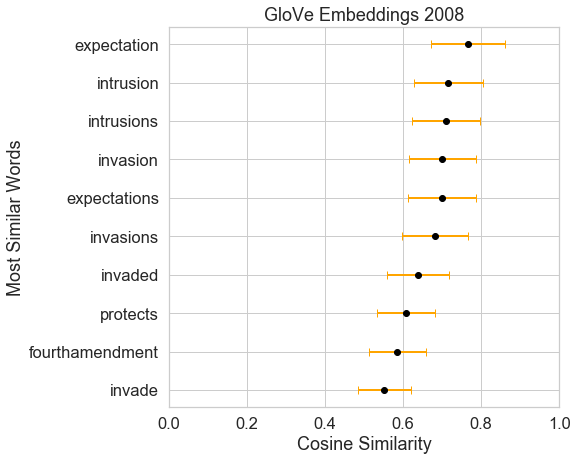

In [530]:
glove08DF['mean'] = glove08DF.mean(axis=1)
glove08DF['std'] = glove08DF.std(axis=1)

glove08DF = glove08DF.sort_values(by='mean', ascending=True)
glove08DF = glove08DF.reset_index()
glove08DF = glove08DF.drop(columns=['index'])

x = glove08DF[4:]['mean']
error = glove08DF[4:]['std']
y = glove08DF[4:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('GloVe Embeddings 2008')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('glove2008.png', bbox_inches='tight')
plt.show()

In [341]:
corpus18 = Corpus(dictionary=W2V_SVD18.word2id)
corpus18.fit(scDF_grouped[:5]['norm_tokens'].sum(), window=WINDOW, ignore_missing=True)
glove18 = Glove(no_components=DIM, learning_rate=0.05)
glove18.fit(matrix=corpus18.matrix, epochs=10, no_threads=WORKERS, verbose=True)

Performing 10 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [343]:
glove18.add_dictionary(corpus18.dictionary)
glove18.most_similar('privacy', number=10)

[('expectation', 0.7938328528860217),
 ('intrusion', 0.7563771679412975),
 ('intrusions', 0.7397514786709093),
 ('invasion', 0.7335415289522942),
 ('invasions', 0.7032095287696551),
 ('expectations', 0.6958286213113886),
 ('invaded', 0.6769108699218361),
 ('protects', 0.6512201548140484),
 ('fourthamendment', 0.6170652764249334)]

In [344]:
glove18DF = pd.DataFrame(glove18.most_similar('privacy', number=15), columns=['word', 'cosine_sim'])

for i in range(50):
    glove18 = Glove(no_components=DIM, learning_rate=0.05)
    glove18.fit(matrix=corpus18.matrix, epochs=12, no_threads=WORKERS, verbose=True)
    glove18.add_dictionary(corpus18.dictionary)
    tempDF = pd.DataFrame(glove18.most_similar('privacy', number=15), columns=['word', 'cosine_sim'])
    glove18DF = glove18DF.merge(tempDF, how='left', on='word', left_index=True)
    
glove18DF.to_csv('glove18DF.csv', index=False)

Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Performing 12 training epochs with 12 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
E

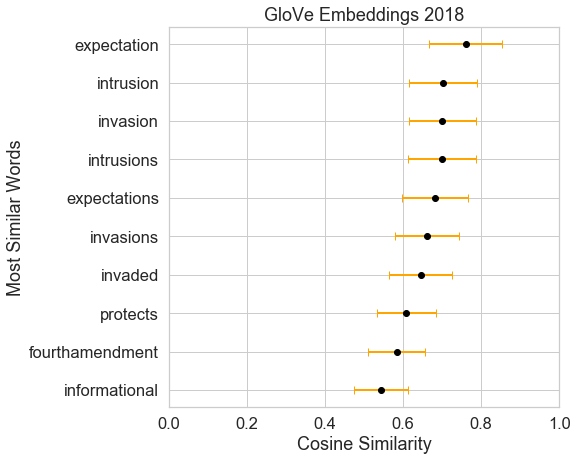

In [531]:
glove18DF['mean'] = glove18DF.mean(axis=1)
glove18DF['std'] = glove18DF.std(axis=1)

glove18DF = glove18DF.sort_values(by='mean', ascending=True)
glove18DF = glove18DF.reset_index()
glove18DF = glove18DF.drop(columns=['index'])

x = glove18DF[4:]['mean']
error = glove18DF[4:]['std']
y = glove18DF[4:]['word']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,7))
plt.title('GloVe Embeddings 2018')
plt.xlabel('Cosine Similarity')
plt.ylabel('Most Similar Words')
plt.xlim(0, 1)
plt.errorbar(x, y, xerr=error, fmt='o', elinewidth=2, markersize=6, capsize=4, color='black', ecolor='orange')
# plt.savefig('glove2018.png', bbox_inches='tight')
plt.show()

In [416]:
glove_std = pd.concat([glove78DF['std'], glove88DF['std'], glove98DF['std'], glove08DF['std'], glove18DF['std']], axis=1, ignore_index=True)

## __4) Standard Deviation Analysis__

Analysing the average standard deviation across time for each model to assess the stability.

In [489]:
temp_cbow = pd.DataFrame(CBOW_std.mean(axis=0), columns=['CBOW'])
temp_sgns = pd.DataFrame(SGNS_std.mean(axis=0), columns=['SGNS'])
temp_svd = pd.DataFrame(SVD_std.mean(axis=0), columns=['SVD'])
temp_glove = pd.DataFrame(glove_std.mean(axis=0), columns=['GloVe'])

stdDF = pd.concat([temp_cbow, temp_sgns, temp_svd, temp_glove], axis=1)

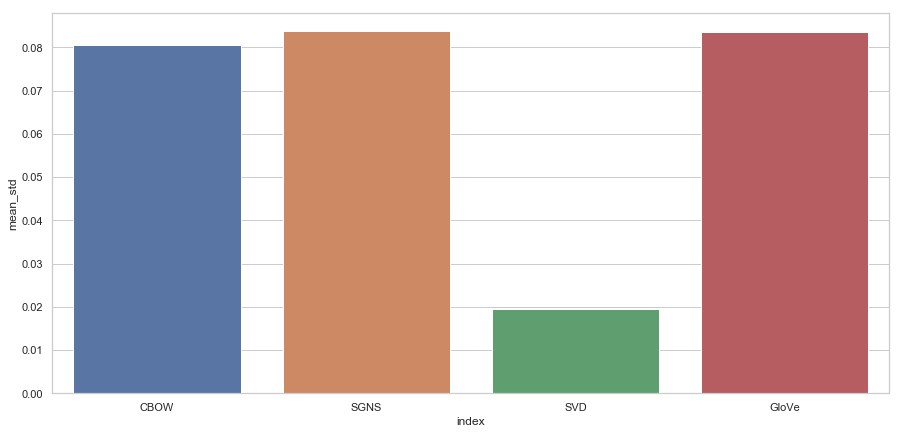

In [490]:
temp_plot = pd.DataFrame(stdDF.mean(axis=0), columns=['mean_std'])
temp_plot = temp_plot.reset_index()

seaborn.set_style("whitegrid")
f, ax = plt.subplots(figsize = (15, 7))
seaborn.set_palette(seaborn.color_palette('muted'))
seaborn.set(font_scale = 1)

seaborn.barplot(x=temp_plot['index'], y=temp_plot['mean_std'])
# plt.xticks(rotation=90)
# plt.savefig('uscmerged_issues.png')
plt.show()